# Estimate Indirect Nutrient flux to coastal Watersheds

# part 1:imports

In [1]:
# Importing libraries
import os
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib.dates as mdates
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap, LogNorm
import re 
import pylag
from shapely.geometry import Point
import contextily as ctx
import datetime

# path to Data

In [2]:
# define the path to the data directory
data_dir = '/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/output'

# Create a geodataframe

In [3]:
# read particle tracking output files
def sort_key(file):
    # Extract the filename from the file path
    filename = os.path.basename(file)
    # Extract the number from the filename
    number = int(filename.split('__')[1].split('.')[0])
    return number
# Get the output files and sort them using the sort_key function
files = glob.glob(os.path.join(data_dir, 'Fvcome_huron_estuary_2023_Winter_*.nc'))
files.sort(key=sort_key)

# Store individual GeoDataFrames in a list
gdfs = []

# Loop through each NetCDF file
for file in files:
    # Read the dataset
    ds = xr.open_dataset(file)
    
    # Convert the dataset to a DataFrame
    df = ds[['latitude', 'longitude', 'group_id', 'time']].to_dataframe().reset_index()

    # Ensure 'time' is in the DataFrame
    if 'time' not in df.columns:
        raise KeyError("The 'time' column is missing from the DataFrame.")
    
    # Adjust longitude if greater than 0
    df.loc[df['longitude'] > 0, 'longitude'] -= 360

    # Create a list to store GeoDataFrames for each group_id in the current dataset
    unique_group_ids = df['group_id'].unique()

    # Loop through each group_id to create individual GeoDataFrames
    for gid in unique_group_ids:
        # Filter rows for the current group_id
        subset = df[df['group_id'] == gid][['time', 'longitude', 'latitude', 'group_id']]

        # If longitude is greater than 0, subtract 360 to correct it
        subset.loc[subset['longitude'] > -0, 'longitude'] -= 360

        # Ensure 'time' is in datetime format
        subset['time'] = pd.to_datetime(subset['time'])
        
        # Create a GeoDataFrame for this subset
        subset_gdf = gpd.GeoDataFrame(subset, geometry=gpd.points_from_xy(subset.longitude, subset.latitude))

        # Append the GeoDataFrame to the list
        gdfs.append(subset_gdf)

# Combine all individual GeoDataFrames into one
combined_gdf = pd.concat(gdfs)

# Set the 'time' column as the index
combined_gdf.set_index('time', inplace=True)

# Drop any unnecessary geometry columns (if present)
combined_gdf = combined_gdf.drop(columns=[col for col in combined_gdf.columns if col.startswith('geometry_') and col != 'geometry'])

# Ensure the final GeoDataFrame is correct
print(combined_gdf.tail(100))

                     longitude   latitude  group_id  \
time                                                  
2023-12-30 12:00:00 -83.596680  43.651913       147   
2023-12-30 12:00:00 -83.439728  43.770046       147   
2023-12-30 12:00:00 -83.591568  43.655369       147   
2023-12-30 12:00:00 -83.595154  43.652771       147   
2023-12-30 18:00:00 -83.598587  43.650833       147   
...                        ...        ...       ...   
2023-12-31 00:00:00 -83.594055  43.653458       147   
2023-12-31 00:00:00 -83.596680  43.651913       147   
2023-12-31 00:00:00 -83.439728  43.770046       147   
2023-12-31 00:00:00 -83.591568  43.655369       147   
2023-12-31 00:00:00 -83.595154  43.652771       147   

                                       geometry  
time                                             
2023-12-30 12:00:00  POINT (-83.59668 43.65191)  
2023-12-30 12:00:00  POINT (-83.43973 43.77005)  
2023-12-30 12:00:00  POINT (-83.59157 43.65537)  
2023-12-30 12:00:00  POINT (-83.59

In [51]:

# Step 1: Reset the index to remove the time index
combined_gdf_remove = combined_gdf.reset_index()

# Step 2: Convert the 'time' column to a string or integer
# Option 1: Convert to string (recommended for dates)
combined_gdf_remove['time'] = combined_gdf_remove['time'].astype(str)

# Option 2: Convert to integer (optional if you want a simpler numeric format)
# combined_gdf_remove['time'] = combined_gdf_remove['time'].astype(int)

# Step 3: Save the GeoDataFrame as a Shapefile
combined_gdf_remove.to_file(os.path.join(data_dir, 'particles.shp'))

# Plotting Particle Tracing versus Group ID

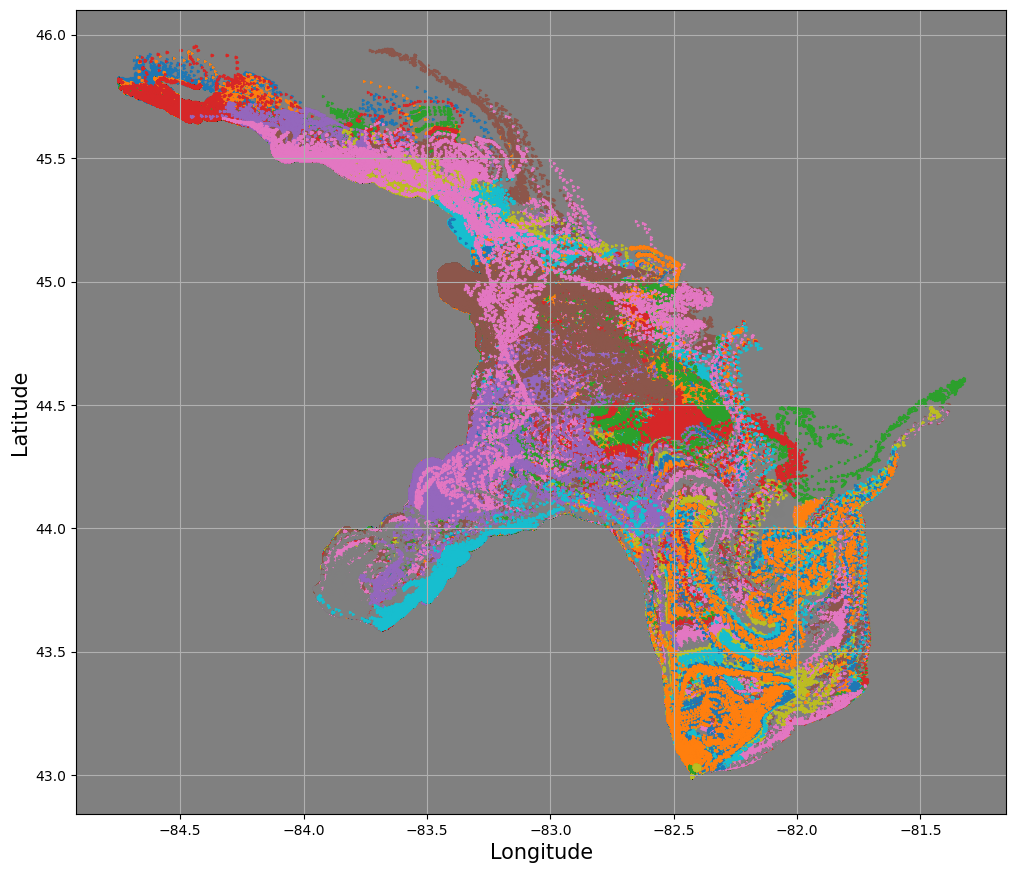

In [7]:
import matplotlib.pyplot as plt

# Create a figure and axis with a specified size
fig, ax = plt.subplots(1, 1, figsize=(12, 18))

# Plot each group_id with a different color
for gid in unique_group_ids:
    subset = combined_gdf[combined_gdf['group_id'] == gid]
    subset.plot(ax=ax, marker='>', label=f'Group {gid}', markersize=2)

# Add a legend with a specified font size
#plt.legend(fontsize=15)

# Add title and labels with specified font sizes
#plt.title('Particle Trajectories along the Huron Jan', fontsize=20)
plt.xlabel('Longitude', fontsize=15)
plt.ylabel('Latitude', fontsize=15)

# Add grid and background color
plt.grid(True)
plt.gca().set_facecolor('grey')

# Save the figure
#plt.savefig('/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/results/particle_tracking_Jan.png')

# Show the plot
plt.show()

# Read coastal watershed shapefiles

In [35]:
# define the path to coastal wetlands shapefile
outErase_Lake_path = "/mnt/d/Users/abolmaal/code/CoastalWatersheds/Erase_lake"
CoastalWatershed_avg = os.path.join(outErase_Lake_path, "CoastalWatershed_avg_erase_lakedrain_LakeHuron_WGS1984.shp")
CoastalWatershed_high = os.path.join(outErase_Lake_path, "CoastalWatershed_high_erase_lakedrain_LakeHuron_WGS1984.shp")
CoastalWatershed_low= os.path.join(outErase_Lake_path, "CoastalWatershed_low_erase_lakedrain_LakeHuron_WGS1984.shp")
CoastalWatershed_surge= os.path.join(outErase_Lake_path, "CoastalWatershed_surge_erase_lakedrain_LakeHuron_WGS1984.shp")



In [36]:
# convert shapefile to geodataframe
CoastalWatershed_avg = gpd.read_file(CoastalWatershed_avg)
CoastalWatershed_high = gpd.read_file(CoastalWatershed_high)
CoastalWatershed_low = gpd.read_file(CoastalWatershed_low)
CoastalWatershed_surge = gpd.read_file(CoastalWatershed_surge)


In [38]:
# change the crs of coastal watershed shapefile to 3174
CoastalWatershed_avg = CoastalWatershed_avg.to_crs(epsg=3174)
CoastalWatershed_high = CoastalWatershed_high.to_crs(epsg=3174)
CoastalWatershed_low = CoastalWatershed_low.to_crs(epsg=3174)
CoastalWatershed_surge = CoastalWatershed_surge.to_crs(epsg=3174)

In [27]:
# print the crs of combined_gdf
#combined_gdf_copy = combined_gdf.set_crs(epsg=4326)
print(combined_gdf_copy.crs)

EPSG:3174


In [22]:
combined_gdf_copy = combined_gdf_copy.to_crs(epsg=3174)
combined_gdf_copy

,longitude,latitude,group_id,geometry
time,,,,
2023-01-01,-84.665833,45.755062,0,POINT (983700.040 1020740.776)
2023-01-01,-84.671844,45.749062,0,POINT (983231.331 1020073.875)
2023-01-01,-84.673828,45.749062,0,POINT (983077.257 1020074.291)
2023-01-01,-84.657837,45.747059,0,POINT (984318.771 1019848.052)
2023-01-01,-84.659851,45.747059,0,POINT (984162.321 1019848.447)
...,...,...,...,...
2023-12-31,-83.594055,43.653458,147,POINT (1069445.247 787172.478)
2023-12-31,-83.596680,43.651913,147,POINT (1069235.627 786998.364)
2023-12-31,-83.439728,43.770046,147,POINT (1081715.335 800286.594)


# Find intersection of particle tracking with coastal watersheds

In [31]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LogNorm
import numpy as np
from pylag.processing.plot import FVCOMPlotter
from pylag.processing.plot import create_figure, colourmap
import cartopy.crs as ccrs
from netCDF4 import Dataset
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from pylag.regrid import regridder
from pylag.processing.ncview import Viewer
from pylag.processing.plot import FVCOMPlotter
from pylag.processing.plot import create_figure
from pylag.processing.utils import get_grid_bands

In [53]:
CW_geo['geometry']

0       POLYGON ((1025348.244 999471.058, 1025298.244 ...
1       POLYGON ((1025298.244 999471.058, 1025348.244 ...
2       POLYGON ((1025681.125 998382.020, 1025698.242 ...
3       POLYGON ((1025672.002 997970.514, 1025698.241 ...
4       POLYGON ((1025842.852 995826.107, 1025850.864 ...
                              ...                        
8200    POLYGON ((1081047.829 572871.652, 1081327.405 ...
8201    POLYGON ((1081647.827 572771.651, 1081647.827 ...
8202    POLYGON ((1081697.827 572721.650, 1081647.827 ...
8203    POLYGON ((1081697.827 572721.650, 1081697.827 ...
8204    POLYGON ((1082147.825 572871.652, 1082147.825 ...
Name: geometry, Length: 8205, dtype: geometry

In [52]:
combined_gdf_copy['geometry']

0          POINT (983700.040 1020740.776)
1          POINT (983231.331 1020073.875)
2          POINT (983077.257 1020074.291)
3          POINT (984318.771 1019848.052)
4          POINT (984162.321 1019848.447)
                        ...              
6608245    POINT (1069445.247 787172.478)
6608246    POINT (1069235.627 786998.364)
6608247    POINT (1081715.335 800286.594)
6608248    POINT (1069643.353 787387.215)
6608249    POINT (1069357.548 787095.152)
Name: geometry, Length: 6608250, dtype: geometry

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Average number of particles entering the Coastal Wetland: 130.0
Percentage of particles from total trajectories that remain in the Coastal Wetland: 100.00%
Average number of particles in each bin:
Bin 0: 0.00 particles
Bin 1: 0.00 particles
Bin 2: 0.00 particles
Bin 3: 0.00 particles
Bin 4: 0.00 particles
Bin 5: 0.00 particles
Bin 6: 0.00 particles
Bin 7: 0.00 particles
Bin 8: 0.00 particles
Bin 9: 0.00 particles
Bin 10: 0.00 particles
Bin 11: 0.00 particles
Bin 12: 0.00 particles
Bin 13: 0.00 particles
Bin 14: 0.00 particles
Bin 15: 0.00 particles
Bin 16: 0.00 particles
Bin 17: 0.00 particles
Bin 18: 0.00 particles
Bin 19: 0.00 particles
Bin 20: 0.00 particles
Bin 21: 0.00 particles
Bin 22: 0.00 particles
Bin 23: 0.00 particles
Bin 24: 0.00 particles
Bin 25: 0.00 particles
Bin 26: 0.00 particles
Bin 27: 0.00 particles
Bin 28: 0.00 particles
Bin 29: 0.00 particles
Bin 30: 0.00 particles
Bin 31: 0.00 particles
Bin 32: 0.00 particles
Bin 33: 0.00 particles
Bin 34: 0.00 particles
Bin 35: 

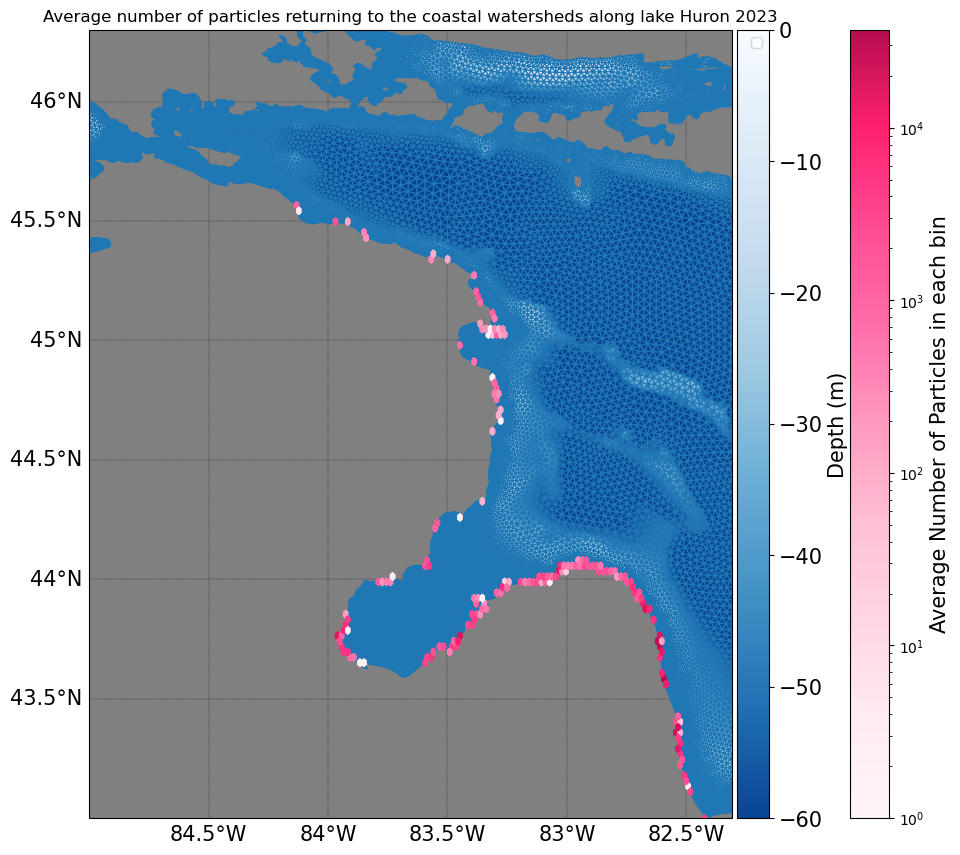

In [60]:
# Load your monthly GeoDataFrames
# Load your monthly GeoDataFrames
monthly_data = {
    'Jan': combined_gdf_copy,
    # Add more months as needed
}
CW_geo = CoastalWatershed_avg
# Ensure all GeoDataFrames use the same CRS
CW_geo_crs = CoastalWatershed_avg.crs


# DataFrame to store particle counts for each polygon across all months
all_particle_counts = pd.DataFrame(columns=['index_right', 'count'])

# Define a list of pink shades for the colormap
pink_shades = ['#fff5f7', '#ffebf0', '#ffd6e1', '#ffbfd4', '#ff99c1', '#ff6ea9', '#ff4c92', '#ff2171', '#b50d4e']
# Create a custom colormap
pink_cmap = LinearSegmentedColormap.from_list('custom_pink', pink_shades)

# Define a list of blue shades for the colormap
# Define a list of blue shades for the colormap and reverse it
blue_shades = ['#f7fbff', '#deebf7', '#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#084594']
blue_shades_reversed = blue_shades[::-1]
# Create a custom colormap
blue_cmap_reversed = LinearSegmentedColormap.from_list('custom_blue_reversed', blue_shades_reversed)



total_particles_intersecting_CW = 0
total_particles_tracked = 0
points_within_CW_list = []
total_particles_list = []

# Store the hexbin data for each month to calculate the average
all_bin_counts = []

# Collect all coordinates for a consistent hexbin grid
all_coords = []

# Iterate over each month's data
for month, combined_gdf_copy in monthly_data.items():
    # Ensure 'time' is a column and convert to datetime
    if 'time' in combined_gdf_copy.index.names:
        combined_gdf_copy.reset_index(inplace=True)
    combined_gdf_copy['time'] = pd.to_datetime(combined_gdf_copy['time'])
    
    # Perform spatial join to find which points fall within the coastal wetland
    points_within_CW = gpd.sjoin(combined_gdf_copy, CW_geo[['geometry']], how='inner', predicate='intersects')
    
    # Ensure 'time' is a column in the intersections and convert to datetime
    if 'time' in points_within_CW.index.names:
        points_within_CW.reset_index(inplace=True)
    points_within_CW['time'] = pd.to_datetime(points_within_CW['time'])
    
    # Sort the intersection by time to find the first intersection for all particles
    points_within_CW = points_within_CW.sort_values(by='time')
    
    # Create a GeoDataFrame for the first intersections using the same CRS
    geometry = gpd.points_from_xy(points_within_CW['longitude'], points_within_CW['latitude'], crs=CW_geo_crs)
    first_intersections_CW = gpd.GeoDataFrame(points_within_CW, geometry=geometry, crs=CW_geo_crs)
    
    # Collect coordinates for hexbin grid
    all_coords.extend(zip(first_intersections_CW.geometry.x, first_intersections_CW.geometry.y))

font_size = 15
cmap = colourmap('h_r')

# Create the figure and axis with FVCOM plotter
fig, ax = create_figure(figure_size=(26., 26.), projection=ccrs.PlateCarree(), font_size=font_size, bg_color='gray')

# Load bathymetry data
grid_metrics_file_name = '/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/input/gridfile/grid_metrics_huron_senseflux_Seasonal_winter.nc'

ds = Dataset(grid_metrics_file_name, 'r')
bathy = -ds.variables['h'][:]
ds.close()

# Configure plotter
plotter = FVCOMPlotter(grid_metrics_file_name, geographic_coords=True, font_size=font_size)
extents = np.array([275, 277.69, 43, 46.3], dtype=float)
ax, plot = plotter.plot_field(ax, bathy, extents=extents, add_colour_bar=True, cb_label='Depth (m)', vmin=-60., vmax=0., cmap=blue_cmap_reversed,zorder=0)

# Overlay grid
plotter.draw_grid(ax, linewidth=1.0)

# Create a hexbin plot to get the consistent grid
hb = ax.hexbin(*zip(*all_coords), gridsize=100, cmap=pink_cmap, norm=LogNorm())
hexbin_grid = hb.get_offsets()

# Initialize an array to accumulate bin counts
accumulated_bin_counts = np.zeros(len(hexbin_grid))

# Iterate over each month's data again to accumulate counts
for month, combined_gdf_copy in monthly_data.items():
    # Ensure 'time' is a column and convert to datetime
    if 'time' in combined_gdf_copy.index.names:
        combined_gdf_copy.reset_index(inplace=True)
    combined_gdf_copy['time'] = pd.to_datetime(combined_gdf_copy['time'])
    
    # Perform spatial join to find which points fall within the coastal wetland
    points_within_CW = gpd.sjoin(combined_gdf_copy, CW_geo[['geometry']], how='inner', predicate='intersects')
    
    # Ensure 'time' is a column in the intersections and convert to datetime
    if 'time' in points_within_CW.index.names:
        points_within_CW.reset_index(inplace=True)
    points_within_CW['time'] = pd.to_datetime(points_within_CW['time'])
    
    # Sort the intersection by time to find the first intersection for all particles
    points_within_CW = points_within_CW.sort_values(by='time')
    
    # Create a GeoDataFrame for the first intersections using the same CRS
    geometry = gpd.points_from_xy(points_within_CW['longitude'], points_within_CW['latitude'], crs=CW_geo_crs)
    first_intersections_CW = gpd.GeoDataFrame(points_within_CW, geometry=geometry, crs=CW_geo_crs)
    
    # Create a hexbin plot with the consistent grid and accumulate counts
    hb = ax.hexbin(first_intersections_CW.geometry.x, first_intersections_CW.geometry.y, gridsize=100, cmap=pink_cmap, norm=LogNorm(), reduce_C_function=np.sum, zorder = 40)
    bin_counts = hb.get_array()
    for i, count in enumerate(bin_counts):
        accumulated_bin_counts[i] += count
    
    # Calculate the total number of particles that intersect the shoreline buffer
    total_particles_intersecting_CW += first_intersections_CW['group_id'].nunique()
    
    # Calculate the total number of particles tracked in the month
    total_particles_tracked += combined_gdf['group_id'].nunique()
    total_particles_list.append(combined_gdf.shape[0])
    points_within_CW_list.append(first_intersections_CW.shape[0])

# Calculate the average bin counts
average_bin_counts = accumulated_bin_counts / len(monthly_data)

# Calculate the average number of particles entering the shoreline buffer
average_particles_entering_CW = total_particles_intersecting_CW / len(monthly_data)

# Calculate the percentage of particles from the total trajectories that remain in the shoreline buffer
percentage_particles_remain_in_CW = (total_particles_intersecting_CW / total_particles_tracked) * 100

print(f'Average number of particles entering the Coastal Wetland: {average_particles_entering_CW}')
print(f'Percentage of particles from total trajectories that remain in the Coastal Wetland: {percentage_particles_remain_in_CW:.2f}%')

# Update the hexbin plot with average bin counts
hb = ax.hexbin(*zip(*hexbin_grid), gridsize=100, C=average_bin_counts, cmap=pink_cmap, norm=LogNorm(), zorder=40)

# Print the average number of particles in each bin
print("Average number of particles in each bin:")
for i, count in enumerate(average_bin_counts):
    print(f"Bin {i}: {count:.2f} particles")

# Set the title of the colormap to the average number of particles that fall within the polygons
ax.set_title('Average number of particles returning to the coastal watersheds along lake Huron 2023')

# Add x and y labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Add a colorbar
cbar = fig.colorbar(hb, ax=ax, pad=0.09)
cbar.set_label('Average Number of Particles in each bin', fontsize=15)

# Adjust layout to make space for colorbar
plt.subplots_adjust(right=1)

# Add legend
plt.legend()
plt.savefig('/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/results/particletracking_coastalwatershed_avginun_2023.png', dpi=300)
# Show the plot
plt.show()


# plot coastal watershed

# Average Inundation

TypeError: unhashable type: 'list'

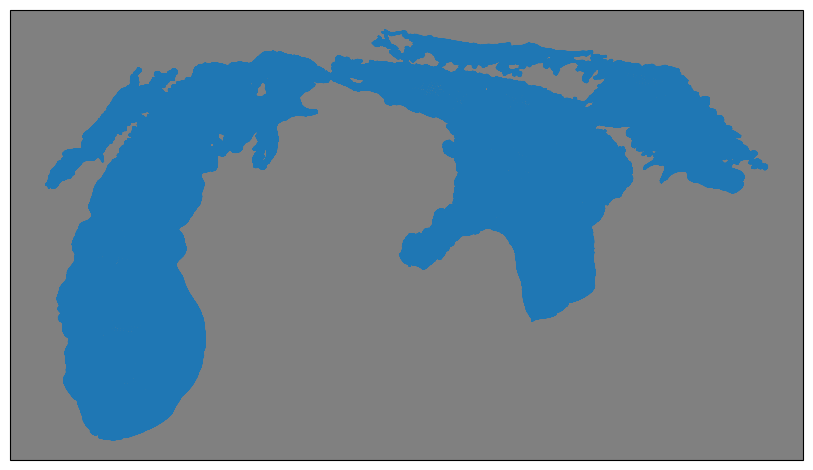

In [47]:
# Define a list of pink shades for the colormap
pink_shades = ['#fff5f7', '#ffebf0', '#ffd6e1', '#ffbfd4', '#ff99c1', '#ff6ea9', '#ff4c92', '#ff2171', '#b50d4e']
# Create a custom colormap
pink_cmap = LinearSegmentedColormap.from_list('custom_pink', pink_shades)

# Define a list of blue shades for the colormap and reverse it
blue_shades = ['#f7fbff', '#deebf7', '#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#084594']
blue_shades_reversed = blue_shades[::-1]

# Define a list of green shades for the colormap
green_shades = ['#e8f5e9', '#c8e6c9', '#a5d6a7', '#81c784', '#66bb6a', '#4caf50', '#43a047', '#388e3c', '#2e7d32']
# Create a custom colormap
green_cmap = LinearSegmentedColormap.from_list('custom_green', green_shades)

# Create a custom colormap
blue_cmap_reversed = LinearSegmentedColormap.from_list('custom_blue_reversed', blue_shades_reversed)
font_size = 15
cmap = colourmap('h_r')

# Create the figure and axis with FVCOM plotter
fig, ax = create_figure( figure_size=(26.,26.),projection=ccrs.PlateCarree(), font_size=font_size, bg_color='gray')

# Load bathymetry data
grid_metrics_file_name = '/home/abolmaal/data/FVCOME_OUTPUT/Simulations/Huron/input/gridfile/grid_metrics_huron_senseflux_Seasonal_winter.nc'
ds = Dataset(grid_metrics_file_name, 'r')
bathy = -ds.variables['h'][:]
ds.close()
# Configure plotter
plotter = FVCOMPlotter(grid_metrics_file_name,
                       geographic_coords=True,
                       font_size=font_size)

# Plot bathymetry
#extents = np.array([-84.10,-84.20, 45.58,45.65], dtype=float)
#extensts = np.array([-84,-81.3, 43,46], dtype=float)
#Lake Huron Ausable Point
extents = np.array([275, 277.69, 43, 46.3], dtype=float)
# ax, plot = plotter.plot_field(ax, bathy, extents=extents, add_colour_bar=True, cb_label='Depth (m)',
#                               vmin=-60., vmax=0., cmap=blue_cmap_reversed, zorder = 0)

# Overlay grid
plotter.draw_grid(ax, linewidth=1.0)


# Plot the coastal wetland data with hexbin
hb = ax.hexbin(CW_geo['start_lat'], CW_geo['start_lon'], gridsize=100, cmap=green_cmap, norm=LogNorm(), zorder=40)

# Add a colorbar
cbar = fig.colorbar(hb, ax=ax, pad=0.09)
cbar.set_label('Coastal Wetland Density',fontsize=15)

# Adjust layout to make space for colorbar
plt.subplots_adjust(right=1)

# Add legend
plt.legend()

# Show the plot
plt.show()

In [49]:
#print the crs of the coastal watershed
print(CW_geo.crs)

EPSG:3174


In [34]:
# add start lat and start_lon to CoastalWatershed_avg


,Id,gridcode,coastal_id,Shape_Area,geometry
0,1,1,1,17375.873064,"POLYGON ((1025348.625 999470.378, 1025298.625 ..."
1,2,2,2,284911.328426,"POLYGON ((1025298.625 999470.378, 1025348.625 ..."
2,3,3,3,1711.645248,"POLYGON ((1025681.509 998381.339, 1025698.625 ..."
3,4,4,4,20295.491017,"POLYGON ((1025672.386 997969.834, 1025698.625 ..."
4,5,7,5,8575.408470,"POLYGON ((1025843.241 995825.426, 1025851.253 ..."
...,...,...,...,...,...
8200,12228,18015,10157,77602.666617,"POLYGON ((1081048.625 572870.378, 1081328.203 ..."
8201,12229,18009,10158,14970.703125,"POLYGON ((1081648.625 572770.378, 1081648.625 ..."
8202,12230,17978,10159,2500.000000,"POLYGON ((1081698.625 572720.378, 1081648.625 ..."
8203,12231,17983,10160,2500.000000,"POLYGON ((1081698.625 572720.378, 1081698.625 ..."
